In [1]:
import numpy as np
import datetime

import matplotlib.pyplot as plt

In [2]:
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from seaborn import heatmap

In [3]:
from sklearn.cluster import KMeans
from sklearn.cluster import spectral_clustering

In [4]:
def get_B_and_weight_vec(matrix,threshold):
    N = matrix.shape[0]
    A = matrix

    row = []
    col = []
    data = []
    weight_vec = []
    cnt = 0
    for i in range(N):
        for j in range(N):
            if j <= i:
                continue
            if A[i, j] < threshold:   
                A[i, j] = 0
                A[j, i] = 0
                continue
            row.append(cnt)
            col.append(i)
            data.append(1)

            row.append(cnt)
            col.append(j)
            data.append(-1)
            cnt += 1
            weight_vec.append(A[i, j])

    B = csr_matrix((data, (row, col)), shape=(cnt, N))
    weight_vec = np.array(weight_vec)
    return B, weight_vec

In [5]:
def algorithm(B, weight_vec,seeds, K=15000,alpha=0.01, lambda_nLasso=None, check_s=False):
    E, N = B.shape
#     weight_vec = np.ones(E)

    Gamma_vec = np.array(1./(np.sum(abs(B), 0)))[0]  # \in [0, 1]
    Gamma = np.diag(Gamma_vec)

    Sigma = 0.5
    
    
    seednodesindicator= np.zeros(N)
    seednodesindicator[seeds] = 1   
    
    noseednodeindicator = np.ones(N)
    noseednodeindicator[seeds] = 0
    
    if lambda_nLasso == None:
        lambda_nLasso = 2 / math.sqrt(np.sum(weight_vec))
    
    if check_s:
        s = 0.0
        for item in range(len(weight_vec)):
            x = B[item].toarray()[0]
            i = np.where(x == -1)[0][0]
            j = np.where(x == 1)[0][0]
            if i < N1 <= j:
                s += weight_vec[item]
            elif i >= N1 > j:
                s += weight_vec[item]

        if lambda_nLasso * s >= alpha * N2 / 2:
            print ('eq(24)', lambda_nLasso * s, alpha * N2 / 2)
    
    fac_alpha = 1./(Gamma_vec*alpha+1)  # \in [0, 1]

    hatx = np.zeros(N)
    newx = np.zeros(N)
    prevx = np.zeros(N)
    haty = np.array([x/(E-1) for x in range(0, E)])
    history = []
    for iterk in range(K):
        # if 0 < np.max(abs(newx - prevx)) < 1e-4:
        #     print(iterk)
        #     break
        tildex = 2 * hatx - prevx
        newy = haty + Sigma * B.dot(tildex)  # chould be negative
        haty = newy / np.maximum(abs(newy) / (lambda_nLasso * weight_vec), np.ones(E))  # could be negative

        newx = hatx - Gamma_vec * B.T.dot(haty)  # could  be negative
        newx[seeds] = (newx[seeds] + Gamma_vec[seeds]) / (1 + Gamma_vec[seeds])

        newx = seednodesindicator * newx + noseednodeindicator * (newx * fac_alpha)
        prevx = np.copy(hatx)
        hatx = newx  # could be negative
        history.append(newx)
    
    history = np.array(history)

    return history
    
    

# 10 nodes with Various boundary weight

In [799]:
# generate weights matrix
weights_matrix_10 = np.zeros((10,10))
for i in range(100):
    for j in range(10):
        if i == 3:
            weights_matrix_10[i][4] = 0.5
            weights_matrix_10[4][i] = 0.5
            continue
        if j == i+1:
            weights_matrix_10[i][j] = 1
            weights_matrix_10[j][i] = 1

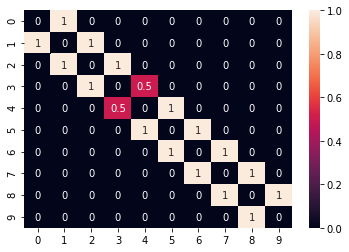

In [800]:
heatmap(weights_matrix_10, annot=True)

In [801]:
def run_chain_10(matrix,seeds,K=100, alpha=0.02,threshold = 0.000001, lambda_nLasso=0.1):

    B, weight_vec = get_B_and_weight_vec(matrix,threshold = threshold)
    print(weight_vec)
    X = []
    for s in seeds:
        history = algorithm(B, weight_vec,seeds=s, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
        X.append(np.nan_to_num(history[-1]))
    X = np.array(X)
    start = datetime.datetime.now()
    spectral_labels = spectral_clustering(matrix, n_clusters=2)
    print ('spectral clustering time: ', datetime.datetime.now() - start)
    return X, spectral_labels

In [802]:
X

array([[0.91743119, 0.91743119, 0.91743119, 0.91743119, 0.91743119,
        0.91743119, 0.91743119, 0.91743119, 0.91743119, 0.91743119],
       [0.71428564, 0.71428564, 0.71428564, 0.71428564, 0.71428564,
        0.71428564, 0.71428564, 0.93137255, 0.93137255, 0.93137255],
       [0.92281553, 0.92281553, 0.92281553, 0.92281553, 0.82499993,
        0.82499993, 0.82499993, 0.82499993, 0.82499993, 0.82499993],
       [0.62499993, 0.62499993, 0.62499993, 0.62499993, 0.62499993,
        0.62499993, 0.62499993, 0.62499993, 0.94059406, 0.94059406],
       [0.91743119, 0.91743119, 0.91743119, 0.91743119, 0.91743119,
        0.91743119, 0.91743119, 0.91743119, 0.91743119, 0.91743119]])

In [811]:
seeds = np.random.choice(np.arange(1,9),5,replace=False)
print("seeds,",seeds)
ALPHA = 0.01
LAMBDA = 0.05
X, spectral_labels = run_chain_10(weights_matrix_10,seeds=seeds,K=3000,\
                                         alpha=ALPHA,lambda_nLasso=LAMBDA)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.T)

seeds, [5 6 1 7 2]
[1.  1.  1.  0.5 1.  1.  1.  1.  1. ]
spectral clustering time:  0:00:00.015396


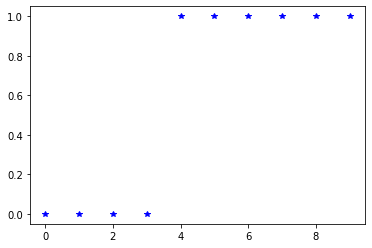

In [812]:
plt.plot(kmeans.labels_,"b*")

In [813]:
true_labels

array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [798]:
true_labels =np.array([0 for i in range(4)]+[1 for i in range(6)])
if kmeans.labels_[0] == 0:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

if spectral_labels[0] == 0:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
else:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    

our method accuracy:  0.6
spectral clustering accuracy:  0.9


In [712]:
from scipy.sparse.csgraph import laplacian
l=laplacian(weights_matrix_10)

In [696]:
import scipy.linalg as la

eig_values, eig_vectors = la.eig(l)
fiedler_pos = np.where(eig_values.real == np.sort(eig_values.real)[1])[0][0]
fiedler_vector = np.transpose(eig_vectors)[fiedler_pos]

print("Fiedler vector: " + str(fiedler_vector.real[0:10]))

Fiedler vector: [ 0.44222566  0.39979621  0.31900823  0.20761292  0.06170762 -0.07552771
 -0.20551652 -0.31578699 -0.39575921 -0.43776021]


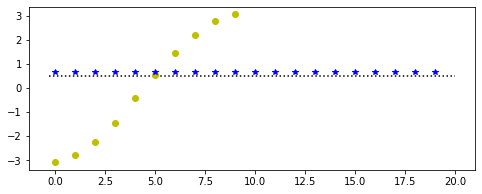

In [697]:
plt.figure(figsize=(8,3))
plt.plot(fiedler_vector.real[0:20]*(-7),'yo')
plt.plot(history[-1][:20],"b*")
plt.hlines(0.5,-0.3,20,linestyles='dotted')

# 100 nodes various boundary weight

In [814]:
# generate weights matrix
weights_matrix_100 = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        if i == 3:
            weights_matrix_100[i][4] = 0.7
            weights_matrix_100[4][i] = 0.7
            continue
        if j == i+1:
            weights_matrix_100[i][j] = 1
            weights_matrix_100[j][i] = 1

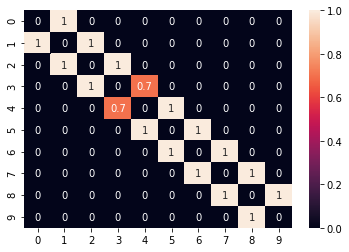

In [815]:
heatmap(weights_matrix_100[:10,:10],annot=True)

In [816]:
def run_chain_100(matrix,seeds, K=30,threshold=0.00001, alpha=0.01, lambda_nLasso=LAMBDA):
    B, weight_vec = get_B_and_weight_vec(matrix,threshold=threshold)
    
    start = datetime.datetime.now()
    X = []
    for s in seeds:
        print(s)
        
        history = algorithm(B, weight_vec,seeds=s, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
        X.append(np.nan_to_num(history[-1]))
    X = np.array(X)
#     print('our method time: ', datetime.datetime.now() - start)
    
    start = datetime.datetime.now()
    spectral_labels = spectral_clustering(matrix, n_clusters=2)
    print ('spectral clustering time: ', datetime.datetime.now() - start)
    
    return X, spectral_labels

In [817]:
seeds = np.random.choice(100,30,replace=False)
ALPHA = 0.005
LAMBDA = 0.3
seeds 

array([ 0, 86, 63, 59, 29, 72, 73, 31, 84, 62, 95, 68,  7, 36,  8, 58, 97,
       24, 44, 79, 80, 45, 53, 69, 77, 90, 10, 48, 14, 43])

In [818]:
X, spectral_labels = run_chain_100(weights_matrix_100,seeds=seeds,K=3000,\
                                         alpha=ALPHA,lambda_nLasso=LAMBDA)
kmeans = KMeans(n_clusters=2, random_state=0).fit(X.T)

0
86
63
59
29
72
73
31
84
62
95
68
7
36
8
58
97
24
44
79
80
45
53
69
77
90
10
48
14
43
spectral clustering time:  0:00:00.077607


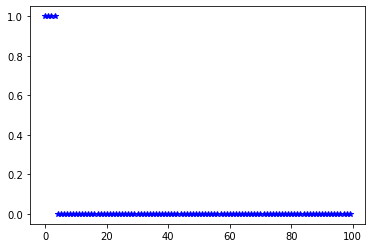

In [458]:
plt.plot(kmeans.labels_,"b*")

In [459]:
true_labels =np.array([0 for i in range(4)]+[1 for i in range(96)])
if kmeans.labels_[0] == 0:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

if spectral_labels[0] == 0:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
else:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    

our method accuracy:  1.0
spectral clustering accuracy:  0.54


In [460]:
from scipy.sparse.csgraph import laplacian
l=laplacian(weights_matrix_100)

In [461]:
import scipy.linalg as la

eig_values, eig_vectors = la.eig(l)
fiedler_pos = np.where(eig_values.real == np.sort(eig_values.real)[1])[0][0]
fiedler_vector = np.transpose(eig_vectors)[fiedler_pos]

print("Fiedler vector: " + str(fiedler_vector.real[0:10]))

Fiedler vector: [0.14146162 0.14132202 0.14104296 0.14062471 0.14000579 0.1393106
 0.13847793 0.13750861 0.13640358 0.13516395]


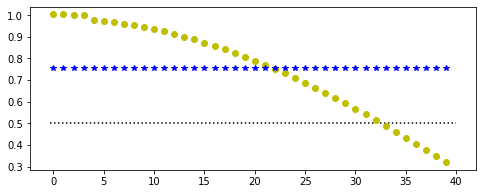

In [207]:
plt.figure(figsize=(8,3))
plt.plot(fiedler_vector.real[0:40]*(-7),'yo')
plt.plot(history[-1][:40],"b*")
plt.hlines(0.5,-0.3,40,linestyles='dotted')

# Chain Graph with 10 nodes

In [10]:
# generate weights matrix
weights_matrix = np.zeros((20,20))
for i in range(20):
    for j in range(20):
        if i == 4:
            weights_matrix[i][5] = 0.9
            weights_matrix[5][i] = 0.9
            continue
        if j == i+1:
            weights_matrix[i][j] = 1
            weights_matrix[j][i] = 1

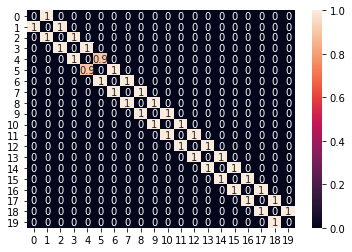

In [11]:
# visulize the weights matrix
heatmap(weights_matrix,annot=True)

In [12]:
def run_chain_10(matrix,seeds,K=100, alpha=0.02,threshold = 0.000001, lambda_nLasso=0.1):

    B, weight_vec = get_B_and_weight_vec(matrix,threshold = threshold)
    print(weight_vec)
    
    start = datetime.datetime.now()
    history = algorithm(B, weight_vec, seeds,K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
    print('our method time: ', datetime.datetime.now() - start)
    
    start = datetime.datetime.now()
    spectral_labels = spectral_clustering(matrix, n_clusters=2)
    print ('spectral clustering time: ', datetime.datetime.now() - start)
    return history, spectral_labels

In [13]:
seeds = np.random.choice([i for i in range(4)],2,replace=False)
print(f"seeds: {seeds}")

seeds: [2 0]


In [14]:
ALPHA = 0.01
LAMBDA = 0.05
history, spectral_labels = run_chain_10(weights_matrix,seeds=seeds,K=3000,alpha=ALPHA,lambda_nLasso=LAMBDA)
kmeans = KMeans(n_clusters=2, random_state=0).fit(history[-1].reshape(len(history[-1]), 1))

[1.  1.  1.  1.  0.9 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 1. ]
our method time:  0:00:00.479504
spectral clustering time:  0:00:00.250445


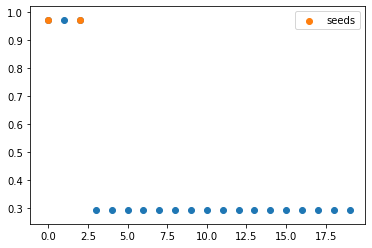

In [15]:
plt.scatter(np.arange(20),history[-1])
plt.scatter(seeds,history[-1][seeds],label='seeds')
plt.legend()

In [16]:
print(spectral_labels)

[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]


In [17]:
print(kmeans.labels_)

[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [18]:
print(f"true labels: {1-true_labels}")

NameError: name 'true_labels' is not defined

In [176]:
kmeans.labels_ -( 1-true_labels)==0

ValueError: operands could not be broadcast together with shapes (20,) (15,) 

In [174]:
np.where(kmeans.labels_ == 1-true_labels)[0]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


array([], dtype=int64)

In [171]:
true_labels =np.array([0]*4+[1]*11)
if kmeans.labels_[0] == 0:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

if spectral_labels[0] == 0:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
else:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    

our method accuracy:  0.0
spectral clustering accuracy:  0.0


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # Remove the CWD from sys.path while we load stuff.


In [163]:
history[-1]

array([ 0.06668287,  0.0658864 ,  0.06353648,  0.05965749,  0.0542937 ,
        0.0475145 ,  0.03942063,  0.03015031,  0.01988432,  0.00884884,
       -0.00268482, -0.01440423, -0.02596399, -0.03699779, -0.04713382,
       -0.05601264, -0.0633061 , -0.06873576, -0.07208937, -0.07323383])

# Chain Graph 100

In [885]:
# generate weights matrix
weights_matrix_100 = np.zeros((100,100))
for i in range(100):
    for j in range(100):
        if i == 3:
            weights_matrix_100[i][4] = 0.1
            weights_matrix_100[4][i] = 0.1
            continue
        if j == i+1:
            weights_matrix_100[i][j] = 1.25
            weights_matrix_100[j][i] = 1.25

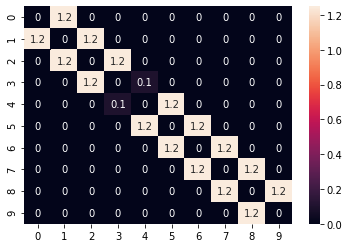

In [886]:
heatmap(weights_matrix_100[:10,:10],annot=True)

In [887]:
def run_chain_100(matrix,seeds, K=30,threshold=0.00001, alpha=ALPHA, lambda_nLasso=LAMBDA):
#     points = get_spirals(N1, N2)
    B, weight_vec = get_B_and_weight_vec(matrix,threshold=threshold)
    
    start = datetime.datetime.now()
    history = algorithm(B, weight_vec,seeds, K=K, alpha=alpha, lambda_nLasso=lambda_nLasso)
    print('our method time: ', datetime.datetime.now() - start)
    
    start = datetime.datetime.now()
    spectral_labels = spectral_clustering(matrix, n_clusters=2)
    print ('spectral clustering time: ', datetime.datetime.now() - start)
    
    return history, spectral_labels

In [888]:
seeds = 0
ALPHA = 0.005
LAMBDA = 0.1

In [889]:
history, spectral_labels = run_chain_100(weights_matrix_100,seeds=seeds,K=1000,\
                                         alpha=ALPHA,lambda_nLasso=LAMBDA)
kmeans = KMeans(n_clusters=2, random_state=0).fit(history[-1].reshape(len(history[-1]), 1))

our method time:  0:00:00.148437
spectral clustering time:  0:00:00.093661


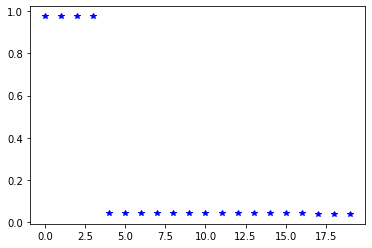

In [890]:
plt.plot(history[-1][:20],"b*")

In [891]:
true_labels =np.array([0 for i in range(4)]+[1 for i in range(96)])
if kmeans.labels_[0] == 0:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == true_labels)[0])/len(true_labels))
else:
    print('our method accuracy: ', len(np.where(kmeans.labels_ == 1-true_labels)[0])/len(true_labels))

if spectral_labels[0] == 0:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == true_labels)[0])/len(true_labels))
else:
    print('spectral clustering accuracy: ', len(np.where(spectral_labels == 1-true_labels)[0])/len(true_labels))
    

our method accuracy:  1.0
spectral clustering accuracy:  0.54


In [892]:
from scipy.sparse.csgraph import laplacian
l=laplacian(weights_matrix_100)

In [893]:
import scipy.linalg as la

eig_values, eig_vectors = la.eig(l)
fiedler_pos = np.where(eig_values.real == np.sort(eig_values.real)[1])[0][0]
fiedler_vector = np.transpose(eig_vectors)[fiedler_pos]

print("Fiedler vector: " + str(fiedler_vector.real[0:10]))

Fiedler vector: [-0.14759928 -0.14745416 -0.14716408 -0.1467293  -0.13949136 -0.13877518
 -0.13792256 -0.13693434 -0.13581149 -0.13455511]


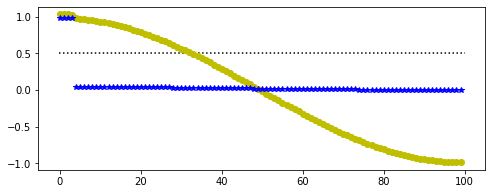

In [894]:
plt.figure(figsize=(8,3))
plt.plot(fiedler_vector.real[0:100]*(-7),'yo')
plt.plot(history[-1][:100],"b*")
plt.hlines(0.5,-0.3,100,linestyles='dotted')